In [1]:
import plotly.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cf.go_offline()

In [3]:
df = pd.read_csv('./cause_death.csv')

# 0. Data exploration

In [4]:
#Data Exploration
df.head()

,YEAR,113_CAUSE_NAME,CAUSE_NAME,STATE,DEATHS,AADR
0,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,Alabama,2313,52.17
1,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,Alaska,294,55.91
2,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,Arizona,2214,44.79
3,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,Arkansas,1287,47.56
4,1999,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional Injuries,California,9198,28.71


In [5]:
display(df['YEAR'].unique())
display(df['CAUSE_NAME'].unique())

array([1999, 2000, 2001, 2002, 2005, 2007, 2010, 2012, 2003, 2004, 2006,
       2008, 2009, 2011, 2013], dtype=int64)

array(['Unintentional Injuries', 'All Causes', "Alzheimer's disease",
       'Homicide', 'Stroke', 'Chronic liver disease and cirrhosis',
       'CLRD', 'Diabetes', 'Diseases of Heart',
       'Essential hypertension and hypertensive renal disease',
       'Influenza and pneumonia', 'Cancer', 'Suicide', 'Kidney Disease',
       "Parkinson's disease", 'Pneumonitis due to solids and liquids',
       'Septicemia'], dtype=object)

In [6]:
display(df.describe().transpose())
display(df.info())

,count,mean,std,min,25%,50%,75%,max
YEAR,13260.0,2006.0,4.320657,1999.0,2002.0,2006.0,2010.0,2013.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13260 entries, 0 to 13259
Data columns (total 6 columns):
YEAR              13260 non-null int64
113_CAUSE_NAME    13260 non-null object
CAUSE_NAME        13260 non-null object
STATE             13260 non-null object
DEATHS            13260 non-null object
AADR              13260 non-null object
dtypes: int64(1), object(5)
memory usage: 621.6+ KB


None

In [7]:
df.columns = df.columns.str.lower()
df = df.rename(columns={'cause_name':'death_cause','deaths':'death_number','aadr':'age'})
df.columns

Index(['year', '113_cause_name', 'death_cause', 'state', 'death_number',
       'age'],
      dtype='object')

# 2. Data cleaning

In [8]:
#Data cleaning: droping a column
df.drop(['113_cause_name'], axis=1, inplace=True)

In [9]:
#Data cleaning: changing data types

# Found an 'x' on the 'death_number' string to numeric; converted to 0
# Also in the 'age' column, a '*' was converted to 0

# The 'state' named as 'United States' is the sum of all states. It generates noise in the df. 
# So, the state 'United States' will be removed. The same applies for the 'All causes' label from the 'cause_name' column.
# Test: df[(df['state']=='United States') ] #97860 is equal to 
#df[(df['state']!='United States') & (df['death_cause']=='Unintentional Injuries') & (df['year']==1999)].sum()

# Passing by 'age' outlier using the IQR.

try:
    df.loc[df.death_number == 'x'] = 0
except (TypeError, ValueError):
    pass

try:
    df.loc[df.age == '*'] = 0
except (TypeError, ValueError):
    pass

try:
    df = df[df.state != 'United States']
except:
    pass

try:
    df = df[df.death_cause != 'All Causes']
except:
    pass

try:
    df = df[df.death_cause != 0]
except:
    pass

df['death_number'] = pd.to_numeric(df['death_number'])
df['age'] = pd.to_numeric(df['age'])

#Replacing names
df = df.replace({'death_cause':'CLRD'},{'death_cause':'Chronic Respiratory Disease'},regex=True)
checked_df = df.replace({'death_cause':'Essential hypertension and hypertensive renal disease'},{'death_cause':'Essential hypertension'},regex=True)

checked_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12135 entries, 0 to 13259
Data columns (total 5 columns):
year            12135 non-null int64
death_cause     12135 non-null object
state           12135 non-null object
death_number    12135 non-null int64
age             12135 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 568.8+ KB


In [12]:
# Checking age outliers
checked_df['age'].describe()
# There are great number of 'age' (up to 150) that might be the sum of the total number of age deaths.

# Adjusted age for cancer and heart deseases
checked_df['adjusted_age'] = np.where(((checked_df['death_cause'] == 'Cancer')|(checked_df['death_cause'] == 'Diseases of Heart')),
                                      checked_df.death_number/checked_df.age,checked_df.age)

def remove_outlier (df, adjusted_age):
    Q1 = df['adjusted_age'].quantile(0.25)
    Q3 = df['adjusted_age'].quantile(0.75)
    IQR = Q3 - Q1
    fence_high = Q3 + 1.5*IQR
    df_out = df.loc[df['adjusted_age'] < fence_high]
    return df_out
checked_df = remove_outlier(checked_df, checked_df.columns)

checked_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11728 entries, 0 to 13259
Data columns (total 6 columns):
year            11728 non-null int64
death_cause     11728 non-null object
state           11728 non-null object
death_number    11728 non-null int64
age             11728 non-null float64
adjusted_age    11728 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 641.4+ KB


In [15]:
checked_df.to_csv('clean_cause_death.csv')

# 3. Beaking down the data

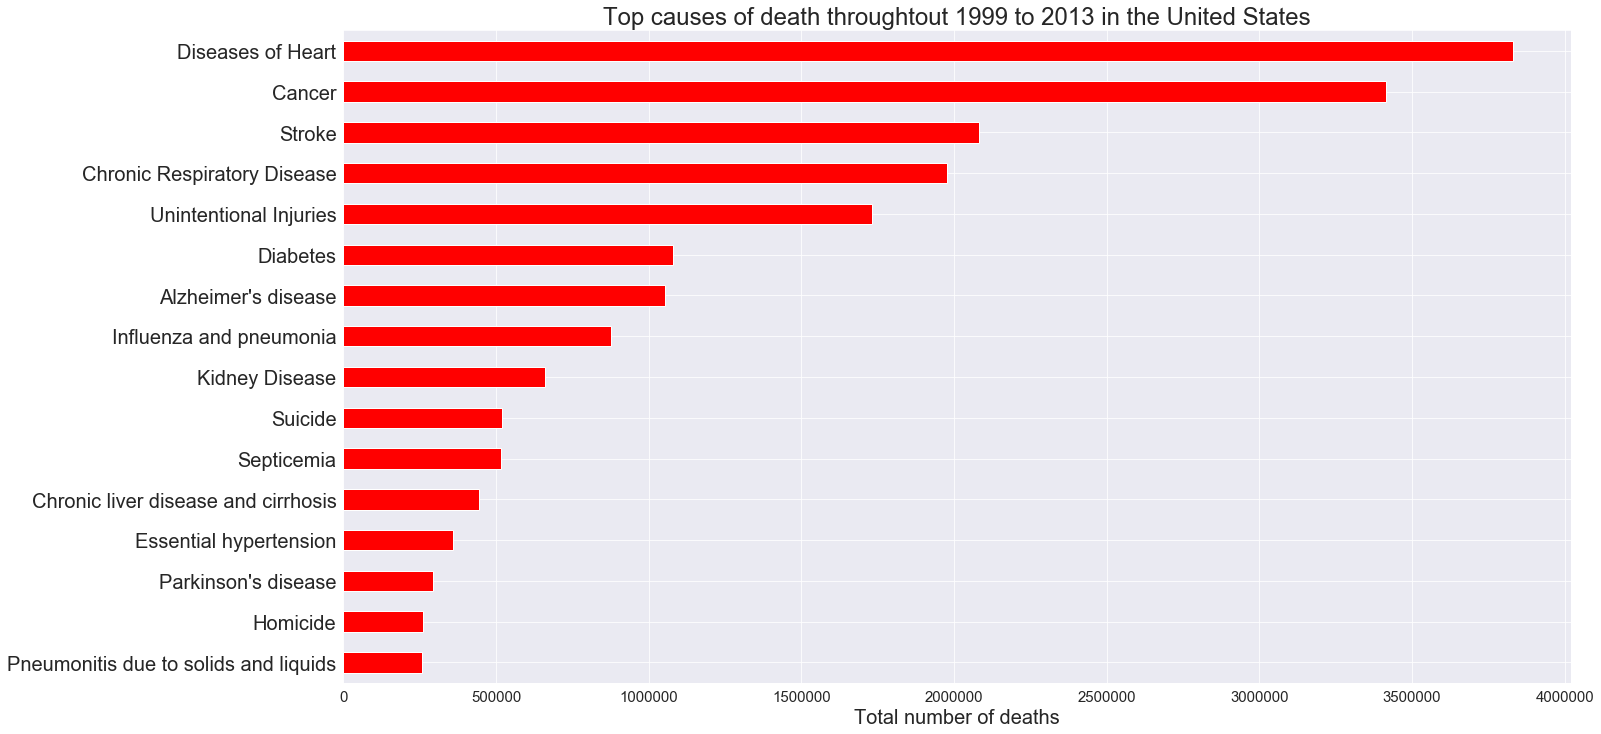

In [88]:
# BAR GRAPH

# Graphic general format
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (22,12)
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size':20})

ax = checked_df.groupby('death_cause').death_number.sum().sort_values(ascending=True).plot(kind='barh', color='r')
plt.title('Top causes of death throughtout 1999 to 2013 in the United States')
ax.set(xlabel='Total number of deaths')
ax.set_ylabel('')

plt.show()
#This graphic describes what's killed the most during a sample of fourteen years on the US. 
#It seems that disease of heart and cancer are the most notable causes of death.

Text(0, 0.5, '')

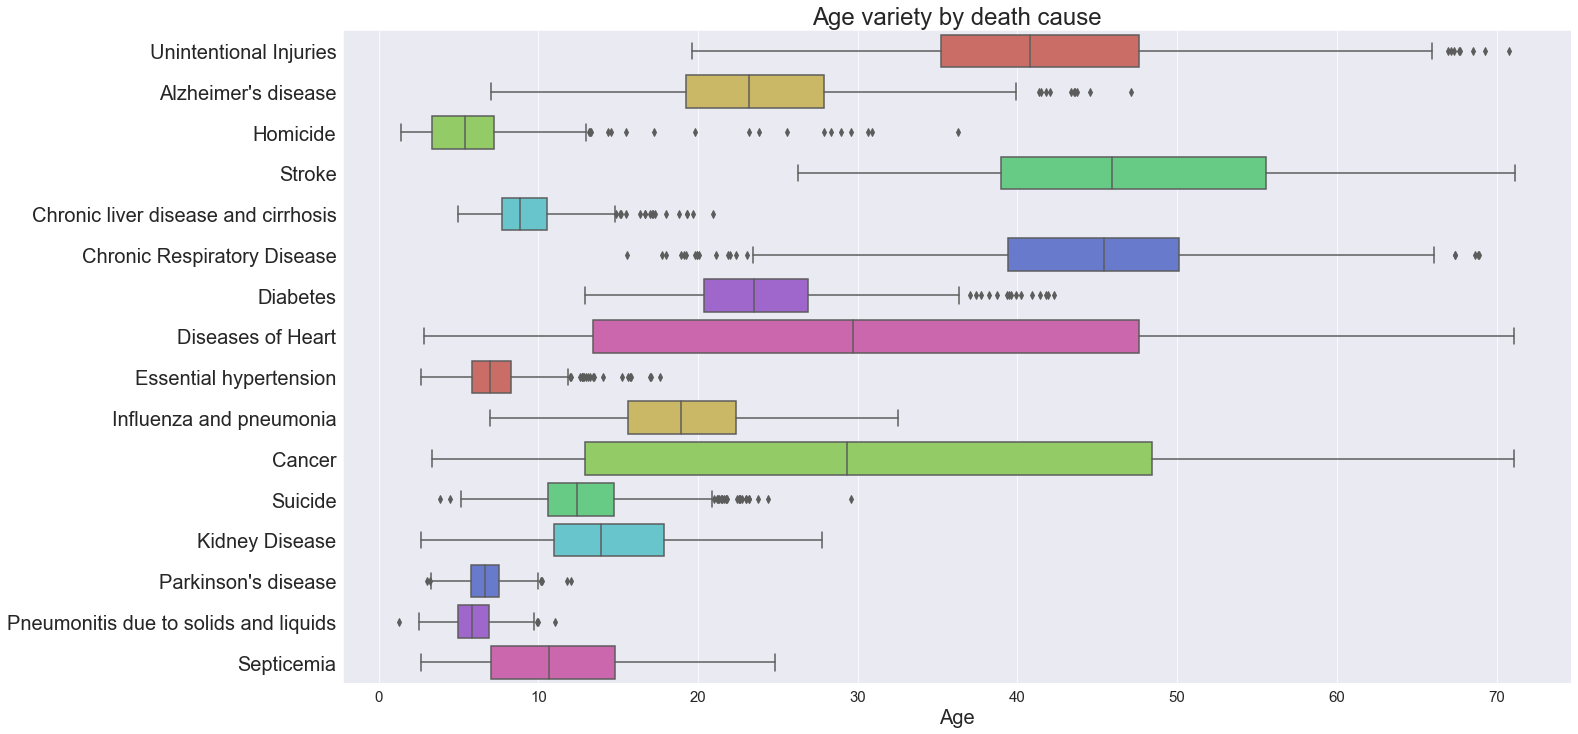

In [41]:
# BOX PLOT

bx = sns.boxplot(data=checked_df, x='adjusted_age', y='death_cause', orient='h', palette=sns.color_palette("hls",8))
plt.title('Age variety by death cause')
bx.set(xlabel='Age')
bx.set_ylabel('')

plt.show()
# The following graph describes the historic death age variety for each cause of death.

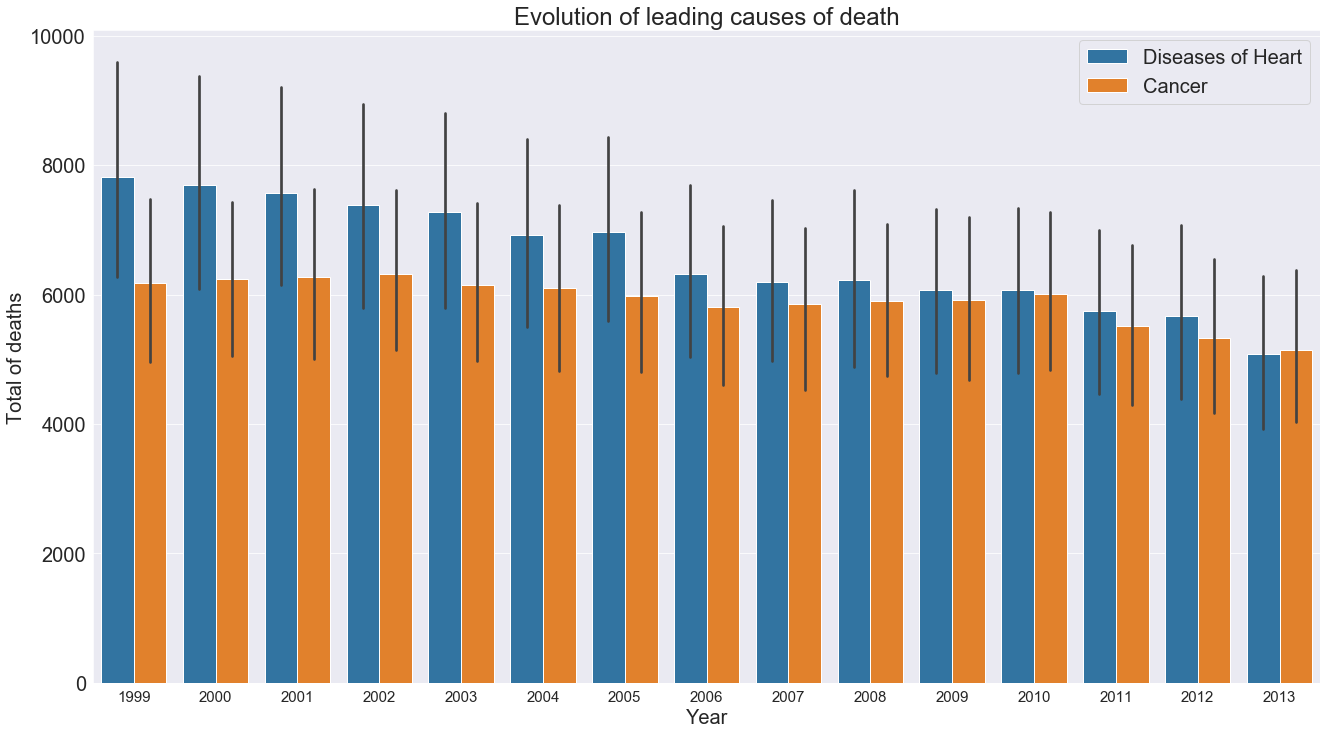

In [107]:
# HISTOGRAM

#Filtering by category
main_causes = ['Cancer', 'Diseases of Heart']
checked_df.death_cause.isin(main_causes)
main_causes_df = checked_df[checked_df.death_cause.isin(main_causes)]
main_causes_df.head()

cx = sns.barplot(data=main_causes_df, x='year', y='death_number', hue='death_cause')
plt.title('Evolution of leading causes of death')
cx.set_xlabel('Year',fontsize=20)
cx.set_ylabel('Total of deaths')
cx.legend(fontsize=20)

plt.show()
# This shows the sum of leading causes of death decreasing steadily year to year.

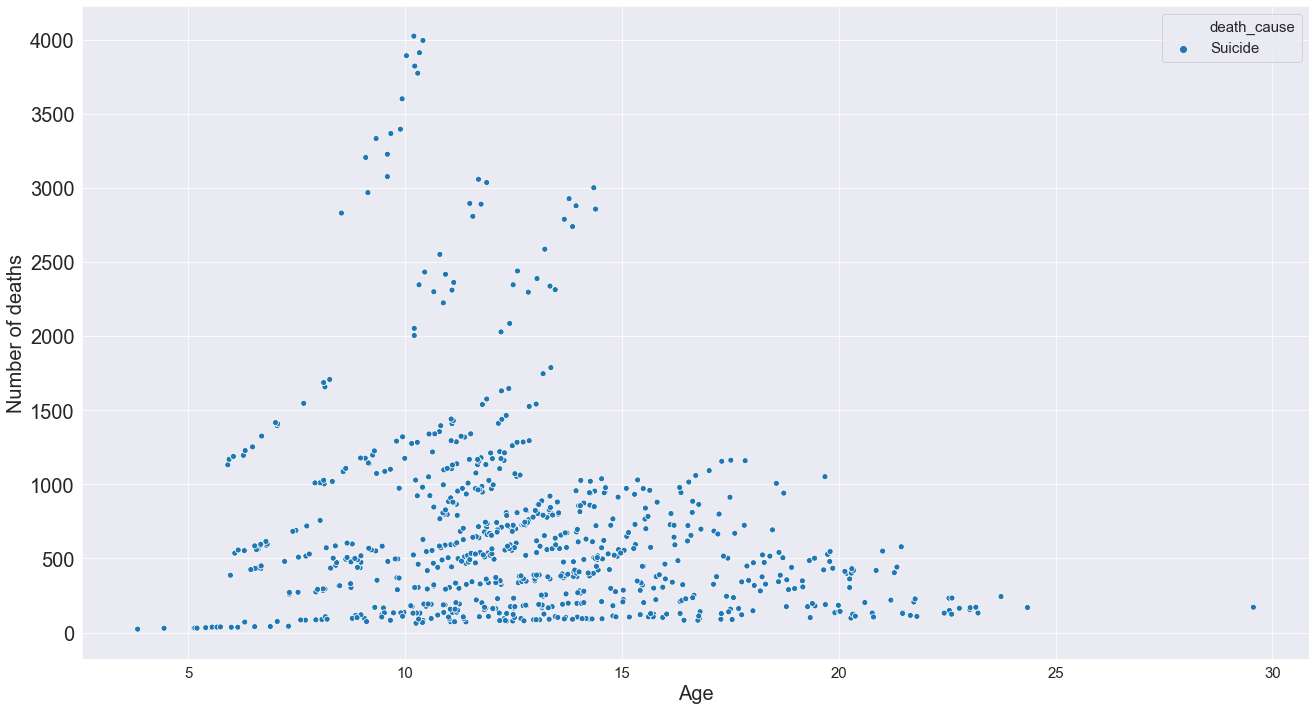

In [115]:
# SCATTER PLOT

#Filter by category
one_cause = ['Suicide']
checked_df.death_cause.isin(one_cause)
one_cause_df = checked_df[checked_df.death_cause.isin(one_cause)]
one_cause_df.head()

cx = sns.scatterplot(data=one_cause_df, x=one_cause_df.adjusted_age, y=one_cause_df.death_number,
                     hue='death_cause')
cx.set_xlabel('Age',fontsize=20)
cx.set_ylabel('Number of deaths',fontsize=20)
cx.legend(fontsize=15)

plt.show()
# This graphic shows the main age of young people between 11 and  19 years that commited suicide. 
# The data shows a high dramatic number of cases around the age of 10 :(